In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import texttable

### 1) Some basic information about the files

In [423]:
events = pd.read_csv("Customer1/events.csv")
calls = pd.read_csv("Customer1/calls.csv")
company = pd.read_csv("Customer1/companies.csv")
people = pd.read_csv("Customer1/people.csv")
opport = pd.read_csv("Customer1/opportunities.csv")
events = events.rename(columns={"date": "event_date"})



In [424]:
print('the size of each file: ')
print('events:', len(events))
print('calls:', len(calls))
print('company:', len(company))
print('people:', len(people))
print('opportunity:', len(opport))

the size of each file: 
events: 111525
calls: 367005
company: 31110
people: 64429
opportunity: 3213


In [425]:
print('the columns of each file: ')
print('events: ', events.columns)
print('calls: ', calls.columns)
print('company: ', company.columns)
print('people: ', people.columns)
print('opportunity: ', opport.columns)

the columns of each file: 
events:  Index(['event_date', 'activity_action', 'activity_type', 'contact_id'], dtype='object')
calls:  Index(['date', 'timestamp', 'call_disposition', 'contact_id'], dtype='object')
company:  Index(['company_id', 'industry', 'employee_range'], dtype='object')
people:  Index(['job_level', 'job_function', 'company_id', 'contact_id'], dtype='object')
opportunity:  Index(['company_id', 'created_date'], dtype='object')


In [426]:
events['activity_action'].value_counts()

view                  36547
open                  29646
fill_out              19870
click                 13464
filled_out_form       11789
attended_in_person      209
Name: activity_action, dtype: int64

In [441]:
events['activity_type'].value_counts()


known_web_visit    36547
form_fill          31659
email_open         29646
email_click        13464
attended_event       209
Name: activity_type, dtype: int64

* it can be seen that fill_out and filled_out_form are the same events, so I will use activity_type to merge the table in order to avoid duplicates while merging tables

### 2) Merge a new table 

#### a) Create new tables for events and calls in order to delete the duplicates

In [446]:
new_events = events.groupby(['contact_id', 'event_date', 'activity_type'], as_index = False).count().rename(columns = {'activity_action':'activity_count'})   
new_calls = calls.groupby(['contact_id', 'date', 'call_disposition'], as_index = False).count().rename(columns = {'timestamp':'call_count'})

print('the size of new tables: ')
print('new_events: ', len(new_events))
print('new_calls: ', len(new_calls))


the size of new tables: 
new_events:  99780
new_calls:  266201


In [447]:
new_events.head()

,contact_id,event_date,activity_type,activity_count
0,40008cab9a95789c6,2019-08-20,form_fill,1
1,40008cab9a95789c6,2019-08-20,known_web_visit,1
2,400097495c858cc5b,2019-10-10,form_fill,2
3,4000bb6585ca64a04,2019-08-01,form_fill,1
4,4000bb6585ca64a04,2019-08-01,known_web_visit,1


In [448]:
new_calls.head()

,contact_id,date,call_disposition,call_count
0,4000047a5b09764c,2019-09-19,No Answer,2
1,400008b800968b87b,2019-09-16,No Answer,1
2,400008b800968b87b,2019-09-20,No Answer,1
3,400008b800968b87b,2019-09-24,No Answer,1
4,400008b800968b87b,2019-10-02,No Answer,1


#### b) Merging a new table

In [449]:
a = new_calls.merge(new_events, on = 'contact_id', how = 'inner')
b = a.merge(people, on = 'contact_id', how = 'inner')
merge = b.merge(company, on = 'company_id', how = 'inner')
# merge = c.merge(opport, on = 'company_id', how = 'inner')
# opp = np.zeros(len(d))
# for i in range(len(d)):
#     if merge.iloc[i, 11] in [np.nan]:
#         opp[i] = 0
#     else:
#         opp[i] = 1
# merge['oppor'] = opp
# merge = merge.drop('created_date', axis = 1)
# del merge['company_id']
# del merge['contact_id']

# del merge['activity_action']

merge.head()

,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,company_id,industry,employee_range
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,e215e54457e5469,Manufacturing,0 - 9
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99


In [432]:
opp = np.zeros(len(merge))
for i in range(len(merge)):
    if merge['company_id'][i] in opport['company_id'].values:
        opp[i] = 1  


In [433]:
merge['opportunity'] = opp
del merge['company_id']


In [434]:
merge.head()


,contact_id,date,call_disposition,call_count,event_date,activity_count,activity_action,job_level,job_function,industry,employee_range,opportunity
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,Healthcare and Medical,0 - 9,0.0
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,Healthcare and Medical,0 - 9,0.0
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,Manufacturing,0 - 9,0.0
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,Software and Technology,50 - 99,0.0
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,Software and Technology,50 - 99,0.0


In [435]:
print('the size of the new table:', len(merge))

the size of the new table: 535307


### 4) Delete all of the None values

In [436]:
merge = merge.dropna()
merge = merge.reset_index(drop=True)

print('size of the table after deleting the None values:', len(merge))

size of the table after deleting the None values: 516763


## 3) Feature Engineering

### a) Adding new features 

#### i) Feature one: the day difference between call date and event day

In [450]:
merge['event_date'] =  pd.to_datetime(merge['event_date'])
merge['event_day'] = pd.Series([merge['event_date'][i].strftime('%a') for i in range(len(merge))])
merge['date'] =  pd.to_datetime(merge['date'])
merge['diff'] = (merge['date'] - merge['event_date']).dt.days 



In [451]:
merge.head()

,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,company_id,industry,employee_range,event_day,diff
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9,Tue,0
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9,Tue,0
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,e215e54457e5469,Manufacturing,0 - 9,Thu,0
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99,Thu,0
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99,Thu,0


Text(0.5, 1.0, 'Day Different Between Events Day and Call Day')

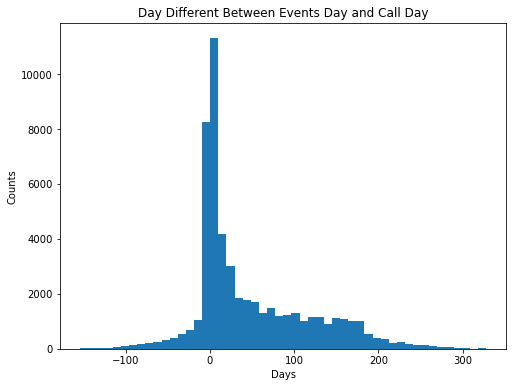

In [439]:
df = merge[merge['call_disposition'].str.contains('MC')]
plt.figure(figsize=(8,6))
plt.hist(x = df['diff'], bins = 50)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.title('Day Different Between Events Day and Call Day')

> * the plot of the day difference using the calls with meaningful conversation
> * it can be seen that most of the meaningful conversation was made within few days after the customers' activities related to 6Sense

#### ii) Feature two: the total count of activity action for each contact_id

In [467]:
total_count = merge.groupby('contact_id', as_index = False).size().rename(columns={'size':'total count'})

merge = merge.merge(total_count, on = 'contact_id')
merge.head()    


,contact_id,date,call_disposition,call_count,event_date,activity_type,activity_count,job_level,job_function,company_id,industry,employee_range,event_day,diff,total count
0,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,form_fill,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9,Tue,0,2
1,40008cab9a95789c6,2019-08-20,MC - No Need,1,2019-08-20,known_web_visit,1,Other,Other,.812e6c37a26b2d2,Healthcare and Medical,0 - 9,Tue,0,2
2,400097495c858cc5b,2019-10-10,No Answer,1,2019-10-10,form_fill,2,C-Level,Management,e215e54457e5469,Manufacturing,0 - 9,Thu,0,1
3,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,form_fill,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99,Thu,0,28
4,4000bb6585ca64a04,2019-08-01,No Answer,1,2019-08-01,known_web_visit,1,Manager,Information Technology,afca90b262cd9d0,Software and Technology,50 - 99,Thu,0,28


In [ ]:
# target = d['call_day']
# features = d.drop(['call_day','call_month'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# target = d['call_day']
# features = d.drop(['call_day','call_month', 'oppor'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)

# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# target = d['call_day']
# features = d.drop(['call_day'],axis=1)

# x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# model = RandomForestRegressor()
# model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# training_accuracy = model.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = model.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# knn = KNeighborsClassifier(n_neighbors = 3)                 
# knn.fit(x_train, y_train)                                     

# training_accuracy = knn.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = knn.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)


In [ ]:
# svc = SVC(kernel='poly', C=100)                                             
# svc.fit(x_train, y_train)                                       

# training_accuracy = svc.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = svc.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
# perceptron = Perceptron()                           
# perceptron.fit(x_train, y_train)                                     

# training_accuracy = perceptron.score(x_train, y_train)
# print ('Training Accuracy:',training_accuracy)
# test_accuracy = perceptron.score(x_test, y_test)
# print ('Testing Accuracy:',test_accuracy)

In [ ]:
import seaborn as sns
t = d.groupby(['job_level', 'call_disposition'], as_index = False)[['company_id']].count()
t = t.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t['job_level'], y = t['count'], hue = t['call_disposition'])
plt.title("Activity (Calls) Count by Different Job Level ")
plt.savefig('sample1.png')
# the frequency of different job level people response to the call

In [ ]:
t1 = d.groupby(['job_level', 'activity_type'], as_index = False)[['company_id']].count()
t1 = t1.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t1['job_level'], y = t1['count'], hue = t1['activity_type'])
plt.title("Activity (Emails) Count by Different Job Level ", fontsize=20)
plt.savefig('sample2.png')

In [ ]:
t3 = d.groupby(['hour', 'call_disposition'], as_index = False)[['company_id']].count()
t3 = t3.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t3['hour'], y = t3['count'], hue = t3['call_disposition'])
plt.title("Activity (Calls) Count by Hours")
plt.savefig('sample3.png')

In [ ]:
t4 = d.groupby(['day', 'job_level'], as_index = False)[['company_id']].count()
t4 = t4.rename(columns = {'company_id':'count'})
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(x = t4['day'], y = t4['count'], hue = t4['job_level'])
plt.title("Daily Activity Count by Different Job Level ")
plt.savefig('sample4.png')